In [2]:
import matplotlib.pyplot as plt
import requests
import pandas as pd
from tqdm import tqdm
import zarr
from wrf_diffusion.nimbuspp.parallel import parallelize
from wrf_diffusion.config import BASE_DIR
import os
base_dir = f'/mnt/lustre/koa/class/atmo449_class/team_1_flood_risk/'

In [ ]:
# documentation
# https://help.waterdata.usgs.gov/faq/automated-retrievals

# Example URL to get site metadata
# https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=16103000

In [24]:
# Hanalei River nr Hanalei, Kauai, HI - USGS-16103000
site_id = '16103000'
minor_threshold = 5
major_threshold = 15.8
station_begin_date = pd.Timestamp('1990-10-01')
station_end_date = pd.Timestamp.utcnow().tz_localize(None).floor('1D')
# https://waterdata.usgs.gov/monitoring-location/USGS-16103000/#dataTypeId=continuous-00065-0&startDT=2018-01-01&endDT=2018-12-31

In [ ]:
import pandas as pd

def generate_chunks(start_date: str, end_date: str, months: int = 1):
    """
    Generate (start, end) date ranges between start_date and end_date
    with each chunk spanning up to `months` months.
    
    Args:
        start_date (str): Start date in YYYY-MM-DD format.
        end_date   (str): End date in YYYY-MM-DD format.
        months (int): Number of months per chunk (default=3).
    
    Returns:
        list of (str, str): List of (start, end) date ranges.
    """
    # Generate boundaries stepping every `months`
    boundaries = pd.date_range(start=start_date, end=end_date, freq=f"{months}MS")  # MS = month start
    if boundaries[-1] != pd.to_datetime(end_date).replace(day=1):
        boundaries = boundaries.append(pd.DatetimeIndex([pd.to_datetime(end_date) + pd.offsets.MonthBegin(1)]))
    
    ranges = []
    for i in range(len(boundaries)-1):
        start = boundaries[i]
        # subtract one day from next boundary to make inclusive
        end = boundaries[i+1] - pd.Timedelta(days=1)
        if end > pd.to_datetime(end_date):
            end = pd.to_datetime(end_date)
        ranges.append((start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d")))
    return ranges

In [50]:
# # download only works in three-month chunks.
# chunk_starts = pd.date_range(station_begin_date, station_end_date)
# (chunk_starts[0] + pd.tseries.offsets.MonthEnd(3)).to_timestamp()

In [171]:
def retrieve_data(start_timestamp: pd.Timestamp, end_timestamp: pd.Timestamp):
    if end_timestamp - start_timestamp > pd.Timedelta(days=61): raise ValueError('Requesting too much data.')
    url = f"https://nwis.waterservices.usgs.gov/nwis/iv/?sites={site_id}&agencyCd=USGS"
    url += f'&startDT={start_timestamp.strftime("%Y-%m-%d")}T00:00:00.000-10:00&endDT={end_timestamp.strftime("%Y-%m-%d")}T23:59:59.999-10:00&parameterCd=00065&format=rdb'
    try:
        lines = requests.get(url).text.split('\n')
        timestamps, measurements, flags = [], [], []
        for l in lines:
            if not l.startswith('USGS'): continue
            data_tuple = l.split('\t')
            [timestamps.append(data_tuple[2]), measurements.append(data_tuple[4]), flags.append(data_tuple[5])]
        df = pd.DataFrame(data={'utc_timestamp': pd.to_datetime(timestamps).tz_localize('HST').tz_convert('HST'), 'measurement': measurements, 'DQF': flags})
    except Exception as e:
        print(f'Error while processing {start_timestamp=}, {end_timestamp=}')
        print(e)
    return df

def helper_retrieve_data(args):
    return retrieve_data(args['start_timestamp'], args['end_timestamp'])

In [186]:
f"https://waterservices.usgs.gov/nwis/site/?format=rdb&sites={site_id}"

'https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=16103000'

In [108]:
# start_timestamp=pd.Timestamp('2023-03-01 00:00:00')
# end_timestamp=pd.Timestamp('2023-04-30 00:00:00')
# url = f"https://nwis.waterservices.usgs.gov/nwis/iv/?sites={site_id}&agencyCd=USGS"
# url += f'&startDT={start_timestamp.strftime("%Y-%m-%d")}T00:00:00.000-10:00&endDT={end_timestamp.strftime("%Y-%m-%d")}T23:59:59.999-10:00&parameterCd=00065&format=rdb'
# print(url)

In [172]:
chunks = generate_chunks('1990-01-01', '2025-09-24')

In [173]:
dfs = parallelize(func=helper_retrieve_data, args=[dict(start_timestamp=pd.Timestamp(chunk[0]), end_timestamp=pd.Timestamp(chunk[1])) for chunk in chunks])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 428/428 [00:15<00:00, 27.10it/s]


In [174]:
# dfs = []
# for chunk in tqdm(chunks):
#     df = retrieve_data(pd.Timestamp(chunk[0]), end_timestamp=pd.Timestamp(chunk[1]))
#     dfs.append(df)

In [175]:
df = pd.concat(dfs).query('DQF == "A"').set_index('utc_timestamp').resample('1h').max()# Do not round to mean!

In [180]:
df_focus = df[df.index > '2018-04-01']

(array([1.5277e+04, 9.0356e+04, 9.7860e+03, 1.1770e+03, 2.0000e+02,
        6.4000e+01, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-0.56 ,  1.294,  3.148,  5.002,  6.856,  8.71 , 10.564, 12.418,
        14.272, 16.126, 17.98 ]),
 <BarContainer object of 10 artists>)

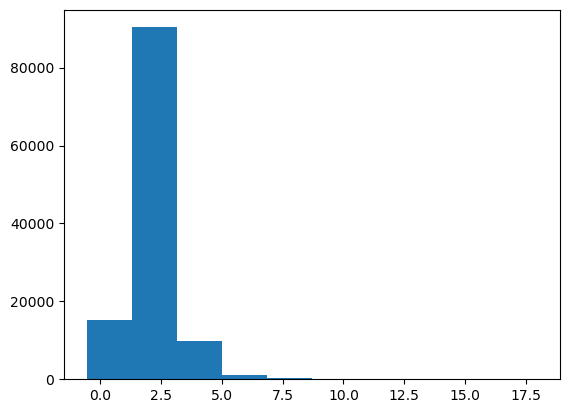

In [183]:
plt.hist(df['measurement'].astype('float'))

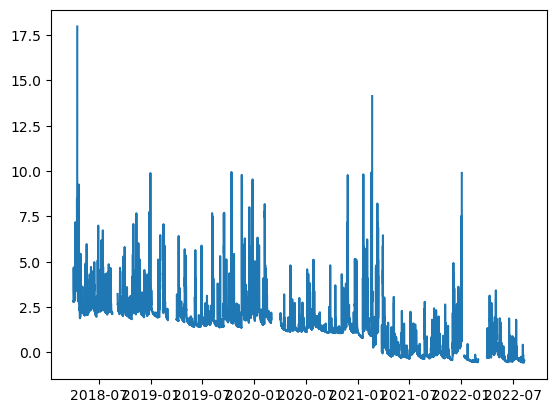

In [181]:
plt.plot(df_focus['measurement'].astype('float'))

TypeError: 'value' must be an instance of str or bytes, not a float

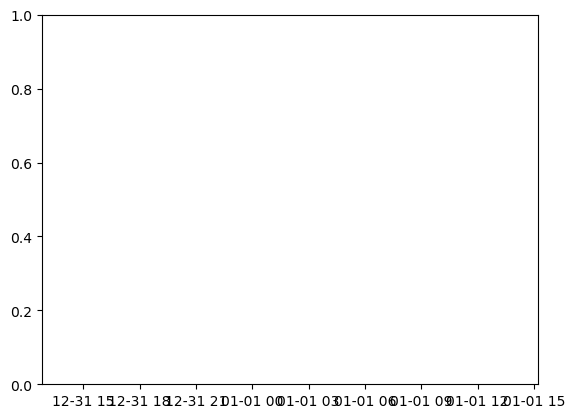

In [ ]:
plt.plot()